In [33]:
from Environment.snake_game import SnakeGame
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import imageio # For video generation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random

In [34]:
class SnakeHeuristic:
    def __init__(self, game: SnakeGame):
        self.game = game
        # Map: game_direction_idx -> (row_change, col_change)
        self.delta_coords = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

    def _get_closest_apple_pos(self):
        if not self.game.apples:
            return None
        
        head_r, head_c = self.game.snake[0]
        closest_apple = None
        min_dist = float('inf')

        for apple_r, apple_c in self.game.apples:
            dist = abs(apple_r - head_r) + abs(apple_c - head_c)
            if dist < min_dist:
                min_dist = dist
                closest_apple = (apple_r, apple_c)
        return closest_apple

    def _is_safe_move(self, next_head_r, next_head_c):
        if not (0 <= next_head_r < self.game.height and \
                0 <= next_head_c < self.game.width):
            return False

        if (next_head_r, next_head_c) in self.game.snake[1:]:
            return False
            
        return True

    def choose_action(self):
        target_apple_pos = self._get_closest_apple_pos()

        if target_apple_pos is None:
            return 0

        head_r, head_c = self.game.snake[0]
        current_game_direction = self.game.direction

        candidate_actions = []

        for action_value in [-1, 0, 1]:
            next_game_direction = (current_game_direction + action_value) % 4
            if next_game_direction < 0: next_game_direction += 4

            dr, dc = self.delta_coords[next_game_direction]

            next_head_r, next_head_c = head_r + dr, head_c + dc

            if self._is_safe_move(next_head_r, next_head_c):
                dist_to_apple = abs(target_apple_pos[0] - next_head_r) + \
                                abs(target_apple_pos[1] - next_head_c)
                candidate_actions.append({
                    'action': action_value, 
                    'distance': dist_to_apple
                })
        
        if not candidate_actions:
            return 0

        def sort_key(candidate):
            action = candidate['action']
            preference = 0
            if action == 1: preference = 1
            elif action == -1: preference = 2
            return (candidate['distance'], preference)

        candidate_actions.sort(key=sort_key)
        
        return candidate_actions[0]['action']

    def play_game_and_record(self, max_steps: int, video_filename: str = "snake_heuristic_game.gif", fps: int = 5):
        frames = []
        history = {
            'board': [],
            'reward': [],
            'done': -1,
            'info': []
        }
        board_state, reward, done, info = self.game.reset()
        
        frames.append((board_state * 255).astype(np.uint8))

        print(f"Starting game with heuristic. Max steps: {max_steps}. Recording to {video_filename}")

        for step_num in range(max_steps):
            history['board'].append(board_state)
            history['reward'].append(reward)
            history['info'].append(info)
            if done:
                history['done'] = step_num
                print(f"Game ended prematurely at step {step_num} before taking action. Score: {info['score']}")
                break

            action_to_take = self.choose_action()
            board_state, reward, done, info = self.game.step(action_to_take)
            
            frames.append((board_state * 255).astype(np.uint8))
            
            if (step_num + 1) % 100 == 0:
                 print(f"Step {step_num+1}/{max_steps}, Score: {info['score']}, Done: {done}")


            """if done:
                print(f"Game over at step {step_num+1}. Final Score: {info['score']}")
                break"""
        else:
            print(f"Game finished after {max_steps} steps (max_steps reached). Final Score: {self.game.score}")

        if frames:
            print(f"Saving video with {len(frames)} frames at {fps} FPS...")
            try:
                imageio.mimsave(video_filename, frames, fps=fps)
                print(f"Video saved successfully as {video_filename}")
            except Exception as e:
                print(f"Error saving video: {e}")
                print("Please ensure you have an imageio backend installed (e.g., 'pip install imageio[ffmpeg]' for MP4 or 'pip install imageio pillow' for GIF).")
        else:
            print("No frames recorded.")

        return history

In [35]:
GAME_WIDTH = 20
GAME_HEIGHT = 20
FOOD_AMOUNT = 1
GRASS_GROWTH = 0.001
MAX_GRASS = 0.05
BORDER_SIZE = 1 # Add a visual border of 1 pixel
MAX_GAME_STEPS = 500 # Set a limit for the game length
VIDEO_FILENAME = "snake_ai_player.gif"
FPS = 5 # Faster for smoother video

class SnakeDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(SnakeDQN, self).__init__()
        C, H, W = input_shape
        
        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        dummy_input = torch.zeros(1, *input_shape)
        conv_out_size = self.conv(dummy_input).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
def compute_loss(predicted_q_values, actions, target_q_values):
    """
    predicted_q_values: [B, 3]
    actions: [B]  (values in [0, 1, 2])
    target_q_values: [B]
    """
    action_indices = actions + 1
    selected_q = predicted_q_values.gather(1, action_indices.unsqueeze(1)).squeeze(1)
    return F.mse_loss(selected_q, target_q_values)

BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.995
REPLAY_BUFFER_SIZE = 10000
LEARNING_RATE = 1e-4
TARGET_UPDATE_FREQ = 100
EVAL_INTERVAL = 500  # Evaluate every N steps

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.bool)
        )

    def __len__(self):
        return len(self.buffer)

def train_dqn(game_class, max_train_steps=10000):
    game = game_class(GAME_WIDTH, GAME_HEIGHT, FOOD_AMOUNT, BORDER_SIZE, GRASS_GROWTH, MAX_GRASS)
    n_actions = 3

    state = game.reset()[0]
    state = np.transpose(state, (2, 0, 1))  # (C, H, W)
    state_shape = state.shape
    policy_net = SnakeDQN(state_shape, n_actions)
    target_net = SnakeDQN(state_shape, n_actions)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)

    epsilon = EPSILON_START
    total_steps = 0

    for episode in range(1, 10000):
        state, _, done, _ = game.reset()
        state = np.transpose(state, (2, 0, 1))
        #state = np.expand_dims(state, axis=0)  # [1, H, W]

        for _ in range(MAX_GAME_STEPS):
            total_steps += 1

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = [-1, 0, 1][random.randint(0, 2)]
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action_idx = q_values.argmax().item()
                    action = [-1, 0, 1][action_idx]

            next_state, reward, done, info = game.step(action)
            next_state = np.transpose(next_state, (2, 0, 1))
            #next_state = np.expand_dims(next_state, axis=0)

            replay_buffer.push(state, action, reward, next_state, done)

            state = next_state

            # Training step
            if len(replay_buffer) >= BATCH_SIZE:
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                with torch.no_grad():
                    next_q = target_net(next_states).max(1)[0]
                    target_q = rewards + (1 - dones.float()) * GAMMA * next_q

                predicted_q = policy_net(states)
                loss = compute_loss(predicted_q, actions, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if total_steps % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # Evaluation
            if total_steps % EVAL_INTERVAL == 0:
                print(f"\n=== Evaluation at Step {total_steps} ===")
                eval_game = game_class(GAME_WIDTH, GAME_HEIGHT, FOOD_AMOUNT, BORDER_SIZE, GRASS_GROWTH, MAX_GRASS)
                heuristic = SnakeHeuristic(eval_game)
                heuristic.play_game_and_record(MAX_GAME_STEPS, video_filename=f"eval_step_{total_steps}.gif", fps=FPS)

            if done:
                break

        # Decay epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        print(f"Episode {episode}, Steps: {total_steps}, Epsilon: {epsilon:.3f}")

In [36]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)

train_dqn(SnakeGame)

heuristic_player = SnakeHeuristic(game=game_instance)

history = heuristic_player.play_game_and_record(max_steps=MAX_GAME_STEPS, 
                                          video_filename=VIDEO_FILENAME, 
                                          fps=FPS)

Episode 1, Steps: 16, Epsilon: 0.995
Episode 2, Steps: 32, Epsilon: 0.990
Episode 3, Steps: 78, Epsilon: 0.985
Episode 4, Steps: 87, Epsilon: 0.980
Episode 5, Steps: 92, Epsilon: 0.975
Episode 6, Steps: 109, Epsilon: 0.970
Episode 7, Steps: 120, Epsilon: 0.966
Episode 8, Steps: 126, Epsilon: 0.961
Episode 9, Steps: 169, Epsilon: 0.956
Episode 10, Steps: 173, Epsilon: 0.951
Episode 11, Steps: 177, Epsilon: 0.946
Episode 12, Steps: 181, Epsilon: 0.942
Episode 13, Steps: 186, Epsilon: 0.937
Episode 14, Steps: 208, Epsilon: 0.932
Episode 15, Steps: 219, Epsilon: 0.928
Episode 16, Steps: 232, Epsilon: 0.923
Episode 17, Steps: 237, Epsilon: 0.918
Episode 18, Steps: 252, Epsilon: 0.914
Episode 19, Steps: 255, Epsilon: 0.909
Episode 20, Steps: 270, Epsilon: 0.905
Episode 21, Steps: 283, Epsilon: 0.900
Episode 22, Steps: 313, Epsilon: 0.896
Episode 23, Steps: 343, Epsilon: 0.891
Episode 24, Steps: 379, Epsilon: 0.887
Episode 25, Steps: 384, Epsilon: 0.882
Episode 26, Steps: 400, Epsilon: 0.878


KeyboardInterrupt: 

In [5]:
history['info']

[{'score': 0},
 {'score': np.float64(0.05)},
 {'score': np.float64(0.1)},
 {'score': np.float64(0.15000000000000002)},
 {'score': np.float64(0.2)},
 {'score': np.float64(0.25)},
 {'score': np.float64(0.3)},
 {'score': np.float64(0.35)},
 {'score': np.float64(0.39999999999999997)},
 {'score': np.float64(0.44999999999999996)},
 {'score': np.float64(0.49999999999999994)},
 {'score': np.float64(0.5499999999999999)},
 {'score': np.float64(0.6)},
 {'score': np.float64(0.65)},
 {'score': np.float64(0.7000000000000001)},
 {'score': np.float64(1.75)},
 {'score': np.float64(1.8)},
 {'score': np.float64(1.85)},
 {'score': np.float64(1.9000000000000001)},
 {'score': np.float64(1.9500000000000002)},
 {'score': np.float64(2.0)},
 {'score': np.float64(3.05)},
 {'score': np.float64(3.0999999999999996)},
 {'score': np.float64(3.1499999999999995)},
 {'score': np.float64(3.1999999999999993)},
 {'score': np.float64(3.249999999999999)},
 {'score': np.float64(3.299999999999999)},
 {'score': np.float64(4.349

In [6]:
def plot_board(board,text=None):
    plt.figure(figsize=(2,2))
    plt.imshow(board)
    plt.axis('off')
    if text is not None:
        plt.gca().text(3, 3, text, fontsize=45,color = 'yellow')
    #plt.savefig(file_name,bbox_inches='tight')
    plt.show()
    plt.close()

In [7]:
game = SnakeGame(width=14, height = 14, border = 1)
board,reward,done,info = game.reset()
a = {'forw': 0, 'left': -1, 'right': 1}

In [8]:
states = {
    'board': [],
    'reward': [],
    'done': -1,
    'info': []
}

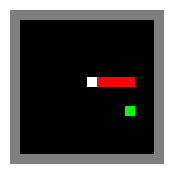

In [9]:
plot_board(board)

In [10]:
board,reward,done,info = game.step(a['left'])

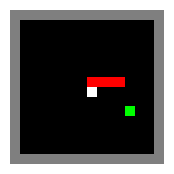

In [11]:
plot_board(board)

In [12]:
board,reward,done,info = game.step(a['right'])

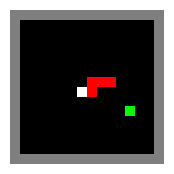

In [13]:
plot_board(board)

In [29]:
board,reward,done,info = game.step(a['right'])

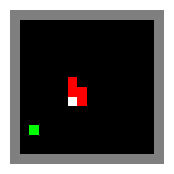

In [30]:
plot_board(board)

In [31]:
board,reward,done,info = game.step(a['forw'])

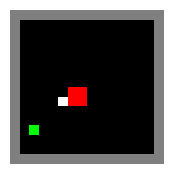

In [32]:
plot_board(board)

In [47]:
board,reward,done,info = game.step(a['forw'])

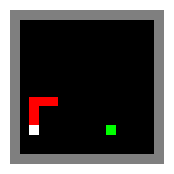

In [48]:
plot_board(board)

In [50]:
done

False